In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
import matplotlib.pyplot as plt
import tqdm

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [3]:
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [4]:
target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [5]:
X = data
Y = target

In [6]:
print(X.shape, Y.shape)

(506, 13) (506,)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=5)

In [8]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((379, 13), (127, 13), (379,), (127,))

In [9]:
class DataMaker(Data.Dataset):

    def __init__(self, X, Y):
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(X)
        self.data = self.data.astype(np.float32)
        self.label = Y.astype(np.float32)

    def __getitem__(self, i):
        return self.data[i, :], self.label[i]

    def __len__(self):
        return len(self.label)

In [10]:
train_set = DataMaker(X_train, Y_train)
test_set = DataMaker(X_test, Y_test)

In [11]:
print(train_set[2])

(array([8.4185791e-05, 8.0000001e-01, 0.0000000e+00, 0.0000000e+00,
       7.6131687e-02, 8.2659513e-01, 2.9969105e-01, 4.7787142e-01,
       1.3043478e-01, 1.2810707e-01, 1.9148937e-01, 9.9326742e-01,
       3.4216337e-02], dtype=float32), 50.0)


In [12]:
class Model(nn.Module):

    def __init__(self, n_features, hidden_layer_1, hidden_layer_2):
        super(Model, self).__init__()

        self.layer_1 = nn.Linear(n_features, hidden_layer_1)
        self.layer_2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.layer_3 = nn.Linear(hidden_layer_2, 1)

    def forward(self, data):
        hid_layer_1 = F.relu(self.layer_1(data))
        hid_layer_2 = F.relu(self.layer_2(hid_layer_1))
        return self.layer_3(hid_layer_2)

In [13]:
torch.manual_seed(5)

In [14]:
batch = 40
train_loder = Data.DataLoader(train_set, batch_size = batch, shuffle = True)
test_loder = Data.DataLoader(test_set, batch_size = batch, shuffle = True)

In [15]:
net = Model(X.shape[1], 200, 100)

In [16]:
net.parameters

<bound method Module.parameters of Model(
  (layer_1): Linear(in_features=13, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
)>

In [17]:
cost = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

In [18]:
n_epochs = 500

all_cost = []

for epoch in range(n_epochs):
    progress_bar = tqdm.tqdm(train_loder, leave = False)
    losses = []
#     count = 0
    for inputs, target in progress_bar:
        optimizer.zero_grad()

        y_pred = net(inputs)  # Forward Propogation

        loss = cost(y_pred, target)

        loss.backward()        # Calculate backward Gradients

        optimizer.step()       # Perform Gradient descent

        progress_bar.set_description(f'Loss: {loss.item()}')

        losses.append(loss.item())

#         count += 1

    epoch_loss = sum(losses)/batch

    all_cost.append(epoch_loss)

    string = f'\t On Epoch: {epoch} Loss: {all_cost[-1]}'

    tqdm.tqdm.write(string)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss: 483.7254333496094:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	 On Epoch: 0 Loss: 120.46504020690918


	 On Epoch: 1 Loss: 53.188267135620116


	 On Epoch: 2 Loss: 26.977857780456542


	 On Epoch: 3 Loss: 22.192280960083007


	 On Epoch: 4 Loss: 21.694114780426027


	 On Epoch: 5 Loss: 21.116674423217773


	 On Epoch: 6 Loss: 21.248283767700194


	 On Epoch: 7 Loss: 21.11834783554077


	 On Epoch: 8 Loss: 21.33842840194702


	 On Epoch: 9 Loss: 22.677032375335692


	 On Epoch: 10 Loss: 21.587557792663574


	 On Epoch: 11 Loss: 21.652148723602295


	 On Epoch: 12 Loss: 22.79200143814087


	 On Epoch: 13 Loss: 21.44876365661621


	 On Epoch: 14 Loss: 20.990030002593993


	 On Epoch: 15 Loss: 21.91652708053589


	 On Epoch: 16 Loss: 22.186294269561767


	 On Epoch: 17 Loss: 23.11067352294922


	 On Epoch: 18 Loss: 21.213630199432373


	 On Epoch: 19 Loss: 21.76944980621338


	 On Epoch: 20 Loss: 20.96111183166504


	 On Epoch: 21 Loss: 21.386621475219727


	 On Epoch: 22 Loss: 21.80948486328125


	 On Epoch: 23 Loss: 21.895480346679687


	 On Epoch: 24 Loss: 21.570474529266356


	 On Epoch: 25 Loss: 21.34006233215332


	 On Epoch: 26 Loss: 22.350125312805176


	 On Epoch: 27 Loss: 21.289700984954834


	 On Epoch: 28 Loss: 21.662621212005615


	 On Epoch: 29 Loss: 21.937351322174074


	 On Epoch: 30 Loss: 21.97655782699585


	 On Epoch: 31 Loss: 22.18386001586914


	 On Epoch: 32 Loss: 21.66205224990845


	 On Epoch: 33 Loss: 21.97044105529785


	 On Epoch: 34 Loss: 21.60477113723755


	 On Epoch: 35 Loss: 21.365327262878417


	 On Epoch: 36 Loss: 22.337572383880616


	 On Epoch: 37 Loss: 21.550856590270996


	 On Epoch: 38 Loss: 21.757098484039307


	 On Epoch: 39 Loss: 21.537942028045656


	 On Epoch: 40 Loss: 21.97495632171631


	 On Epoch: 41 Loss: 22.32828006744385


	 On Epoch: 42 Loss: 20.969552516937256


	 On Epoch: 43 Loss: 22.53249168395996


	 On Epoch: 44 Loss: 22.32303867340088


	 On Epoch: 45 Loss: 22.26632127761841


	 On Epoch: 46 Loss: 22.80608015060425


	 On Epoch: 47 Loss: 21.015457248687746


	 On Epoch: 48 Loss: 21.85278034210205


	 On Epoch: 49 Loss: 22.278828716278078


	 On Epoch: 50 Loss: 20.61800413131714


	 On Epoch: 51 Loss: 21.606609344482422


	 On Epoch: 52 Loss: 22.21974115371704


	 On Epoch: 53 Loss: 22.07550973892212


	 On Epoch: 54 Loss: 21.511632919311523


	 On Epoch: 55 Loss: 22.664330196380615


	 On Epoch: 56 Loss: 22.49265604019165


	 On Epoch: 57 Loss: 22.453051328659058


	 On Epoch: 58 Loss: 22.47459192276001


	 On Epoch: 59 Loss: 22.22592887878418


	 On Epoch: 60 Loss: 22.15137586593628


	 On Epoch: 61 Loss: 21.489542484283447


	 On Epoch: 62 Loss: 21.079406833648683


	 On Epoch: 63 Loss: 20.728893280029297


	 On Epoch: 64 Loss: 21.067036437988282


	 On Epoch: 65 Loss: 21.6987286567688


	 On Epoch: 66 Loss: 22.02782335281372


	 On Epoch: 67 Loss: 21.64848041534424


	 On Epoch: 68 Loss: 21.655214023590087


	 On Epoch: 69 Loss: 21.57082805633545


	 On Epoch: 70 Loss: 21.34607400894165


	 On Epoch: 71 Loss: 21.819748401641846


	 On Epoch: 72 Loss: 21.62952117919922


	 On Epoch: 73 Loss: 22.34172134399414


	 On Epoch: 74 Loss: 20.79165439605713


	 On Epoch: 75 Loss: 21.880607271194457


	 On Epoch: 76 Loss: 21.039725875854494


	 On Epoch: 77 Loss: 22.944824409484863


	 On Epoch: 78 Loss: 21.84598579406738


	 On Epoch: 79 Loss: 22.257427978515626


	 On Epoch: 80 Loss: 21.345999431610107


	 On Epoch: 81 Loss: 21.841130352020265


	 On Epoch: 82 Loss: 21.37274351119995


	 On Epoch: 83 Loss: 21.70134515762329


	 On Epoch: 84 Loss: 20.916765403747558


	 On Epoch: 85 Loss: 21.366861057281493


	 On Epoch: 86 Loss: 21.22971820831299


	 On Epoch: 87 Loss: 21.201287174224852


	 On Epoch: 88 Loss: 21.123163795471193


	 On Epoch: 89 Loss: 21.129244232177733


	 On Epoch: 90 Loss: 22.53966121673584


	 On Epoch: 91 Loss: 21.59481534957886


	 On Epoch: 92 Loss: 21.7961838722229


	 On Epoch: 93 Loss: 21.827464294433593


	 On Epoch: 94 Loss: 22.10361442565918


	 On Epoch: 95 Loss: 21.33190498352051


	 On Epoch: 96 Loss: 21.443604278564454


	 On Epoch: 97 Loss: 21.53224229812622


	 On Epoch: 98 Loss: 21.76754560470581


	 On Epoch: 99 Loss: 21.184575462341307


	 On Epoch: 100 Loss: 21.388961696624754


	 On Epoch: 101 Loss: 21.18341121673584


	 On Epoch: 102 Loss: 20.68633942604065


	 On Epoch: 103 Loss: 20.805808734893798


	 On Epoch: 104 Loss: 21.548065280914308


	 On Epoch: 105 Loss: 20.993382453918457


	 On Epoch: 106 Loss: 21.491569137573244


	 On Epoch: 107 Loss: 23.115970611572266


	 On Epoch: 108 Loss: 22.50397958755493


	 On Epoch: 109 Loss: 21.8614990234375


	 On Epoch: 110 Loss: 20.838766241073607


	 On Epoch: 111 Loss: 22.00247926712036


	 On Epoch: 112 Loss: 22.541401863098145


	 On Epoch: 113 Loss: 21.636386680603028


	 On Epoch: 114 Loss: 21.166811180114745


	 On Epoch: 115 Loss: 21.739530944824217


	 On Epoch: 116 Loss: 21.84939041137695


	 On Epoch: 117 Loss: 21.77165870666504


	 On Epoch: 118 Loss: 21.44328670501709


	 On Epoch: 119 Loss: 21.17260627746582


	 On Epoch: 120 Loss: 21.637082958221434


	 On Epoch: 121 Loss: 22.026638221740722


	 On Epoch: 122 Loss: 21.101439666748046


	 On Epoch: 123 Loss: 21.721805381774903


	 On Epoch: 124 Loss: 22.218003034591675


	 On Epoch: 125 Loss: 21.683792400360108


	 On Epoch: 126 Loss: 21.860079193115233


	 On Epoch: 127 Loss: 21.820677471160888


	 On Epoch: 128 Loss: 21.74092044830322


	 On Epoch: 129 Loss: 21.95479507446289


	 On Epoch: 130 Loss: 21.6775652885437


	 On Epoch: 131 Loss: 20.79131441116333


	 On Epoch: 132 Loss: 21.31180086135864


	 On Epoch: 133 Loss: 22.206720542907714


	 On Epoch: 134 Loss: 21.63617076873779


	 On Epoch: 135 Loss: 20.96596202850342


	 On Epoch: 136 Loss: 20.681348991394042


	 On Epoch: 137 Loss: 21.98865613937378


	 On Epoch: 138 Loss: 21.274870491027833


	 On Epoch: 139 Loss: 21.076014709472656


	 On Epoch: 140 Loss: 22.08086175918579


	 On Epoch: 141 Loss: 21.555979824066164


	 On Epoch: 142 Loss: 21.20728168487549


	 On Epoch: 143 Loss: 21.104328536987303


	 On Epoch: 144 Loss: 22.13717727661133


	 On Epoch: 145 Loss: 21.833360338211058


	 On Epoch: 146 Loss: 24.09422883987427


	 On Epoch: 147 Loss: 22.272081756591795


	 On Epoch: 148 Loss: 22.61722402572632


	 On Epoch: 149 Loss: 21.3861873626709


	 On Epoch: 150 Loss: 21.370229721069336


	 On Epoch: 151 Loss: 21.524915409088134


	 On Epoch: 152 Loss: 22.20648832321167


	 On Epoch: 153 Loss: 21.183600234985352


	 On Epoch: 154 Loss: 21.315620040893556


	 On Epoch: 155 Loss: 20.985496711730956


	 On Epoch: 156 Loss: 20.902239751815795


	 On Epoch: 157 Loss: 21.915069484710692


	 On Epoch: 158 Loss: 21.42181854248047


	 On Epoch: 159 Loss: 20.93857078552246


	 On Epoch: 160 Loss: 21.444937324523927


	 On Epoch: 161 Loss: 21.748418045043945


	 On Epoch: 162 Loss: 21.542530059814453


	 On Epoch: 163 Loss: 22.000289154052734


	 On Epoch: 164 Loss: 22.151555442810057


	 On Epoch: 165 Loss: 21.98701419830322


	 On Epoch: 166 Loss: 22.056018447875978


	 On Epoch: 167 Loss: 22.357303857803345


	 On Epoch: 168 Loss: 21.9494966506958


	 On Epoch: 169 Loss: 20.747269248962404


	 On Epoch: 170 Loss: 21.120734310150148


	 On Epoch: 171 Loss: 22.227655506134035


	 On Epoch: 172 Loss: 22.16976308822632


	 On Epoch: 173 Loss: 22.213780689239503


	 On Epoch: 174 Loss: 22.091326999664307


	 On Epoch: 175 Loss: 21.250597381591795


	 On Epoch: 176 Loss: 20.95437889099121


	 On Epoch: 177 Loss: 21.915526103973388


	 On Epoch: 178 Loss: 21.67261505126953


	 On Epoch: 179 Loss: 21.345084857940673


	 On Epoch: 180 Loss: 22.677335262298584


	 On Epoch: 181 Loss: 20.809206390380858


	 On Epoch: 182 Loss: 22.69547939300537


	 On Epoch: 183 Loss: 22.207536506652833


	 On Epoch: 184 Loss: 21.38969898223877


	 On Epoch: 185 Loss: 21.13540201187134


	 On Epoch: 186 Loss: 22.014514350891112


	 On Epoch: 187 Loss: 21.75410614013672


	 On Epoch: 188 Loss: 20.631604290008546


	 On Epoch: 189 Loss: 21.433285331726076


	 On Epoch: 190 Loss: 22.351609897613525


	 On Epoch: 191 Loss: 23.17742338180542


	 On Epoch: 192 Loss: 21.888303184509276


	 On Epoch: 193 Loss: 21.553527069091796


	 On Epoch: 194 Loss: 21.74996109008789


	 On Epoch: 195 Loss: 21.325568199157715


	 On Epoch: 196 Loss: 20.965220546722414


	 On Epoch: 197 Loss: 21.675049781799316


	 On Epoch: 198 Loss: 21.35189609527588


	 On Epoch: 199 Loss: 22.406135845184327


	 On Epoch: 200 Loss: 21.031890678405762


	 On Epoch: 201 Loss: 22.09402675628662


	 On Epoch: 202 Loss: 21.011259746551513


	 On Epoch: 203 Loss: 21.943626976013185


	 On Epoch: 204 Loss: 21.260080432891847


	 On Epoch: 205 Loss: 21.594986343383788


	 On Epoch: 206 Loss: 20.915310764312743


	 On Epoch: 207 Loss: 21.27733268737793


	 On Epoch: 208 Loss: 21.167406177520753


	 On Epoch: 209 Loss: 21.15067129135132


	 On Epoch: 210 Loss: 21.38883533477783


	 On Epoch: 211 Loss: 21.021021842956543


	 On Epoch: 212 Loss: 21.37005224227905


	 On Epoch: 213 Loss: 21.93550205230713


	 On Epoch: 214 Loss: 21.63520164489746


	 On Epoch: 215 Loss: 21.128641986846922


	 On Epoch: 216 Loss: 21.32020511627197


	 On Epoch: 217 Loss: 21.538444328308106


	 On Epoch: 218 Loss: 22.084756278991698


	 On Epoch: 219 Loss: 21.311500835418702


	 On Epoch: 220 Loss: 21.48118314743042


	 On Epoch: 221 Loss: 21.691378688812257


	 On Epoch: 222 Loss: 21.19369831085205


	 On Epoch: 223 Loss: 21.276170825958253


	 On Epoch: 224 Loss: 22.606976890563963


	 On Epoch: 225 Loss: 21.450552940368652


	 On Epoch: 226 Loss: 21.659754943847656


	 On Epoch: 227 Loss: 22.271514892578125


	 On Epoch: 228 Loss: 21.141751956939697


	 On Epoch: 229 Loss: 21.43226261138916


	 On Epoch: 230 Loss: 22.03330659866333


	 On Epoch: 231 Loss: 21.042023372650146


	 On Epoch: 232 Loss: 22.528470706939697


	 On Epoch: 233 Loss: 21.934408378601074


	 On Epoch: 234 Loss: 22.21287202835083


	 On Epoch: 235 Loss: 22.049603366851805


	 On Epoch: 236 Loss: 21.862817001342773


	 On Epoch: 237 Loss: 21.401897430419922


	 On Epoch: 238 Loss: 21.740838241577148


	 On Epoch: 239 Loss: 21.261631202697753


	 On Epoch: 240 Loss: 21.86689958572388


	 On Epoch: 241 Loss: 21.396809387207032


	 On Epoch: 242 Loss: 21.04457035064697


	 On Epoch: 243 Loss: 20.802487945556642


	 On Epoch: 244 Loss: 21.989309310913086


	 On Epoch: 245 Loss: 22.32125291824341


	 On Epoch: 246 Loss: 21.745659160614014


	 On Epoch: 247 Loss: 20.797712278366088


	 On Epoch: 248 Loss: 21.63162965774536


	 On Epoch: 249 Loss: 21.4193998336792


	 On Epoch: 250 Loss: 21.749930477142335


	 On Epoch: 251 Loss: 21.678856086730956


	 On Epoch: 252 Loss: 22.531779098510743


	 On Epoch: 253 Loss: 23.150352573394777


	 On Epoch: 254 Loss: 21.026054668426514


	 On Epoch: 255 Loss: 21.15961103439331


	 On Epoch: 256 Loss: 21.475250053405762


	 On Epoch: 257 Loss: 21.213953018188477


	 On Epoch: 258 Loss: 21.45645170211792


	 On Epoch: 259 Loss: 21.525833511352538


	 On Epoch: 260 Loss: 21.646601581573485


	 On Epoch: 261 Loss: 21.770291233062743


	 On Epoch: 262 Loss: 21.43225450515747


	 On Epoch: 263 Loss: 22.14953899383545


	 On Epoch: 264 Loss: 21.105203914642335


	 On Epoch: 265 Loss: 21.791540336608886


	 On Epoch: 266 Loss: 21.672483825683592


	 On Epoch: 267 Loss: 21.835258769989014


	 On Epoch: 268 Loss: 21.726090240478516


	 On Epoch: 269 Loss: 22.296383380889893


	 On Epoch: 270 Loss: 21.828594589233397


	 On Epoch: 271 Loss: 20.900296020507813


	 On Epoch: 272 Loss: 21.2709002494812


	 On Epoch: 273 Loss: 21.141301727294923


	 On Epoch: 274 Loss: 21.276425457000734


	 On Epoch: 275 Loss: 21.304602813720702


	 On Epoch: 276 Loss: 21.808369827270507


	 On Epoch: 277 Loss: 22.413233947753906


	 On Epoch: 278 Loss: 22.23733425140381


	 On Epoch: 279 Loss: 21.001571464538575


	 On Epoch: 280 Loss: 21.32573871612549


	 On Epoch: 281 Loss: 21.380702018737793


	 On Epoch: 282 Loss: 21.36339101791382


	 On Epoch: 283 Loss: 22.15966467857361


	 On Epoch: 284 Loss: 21.327126216888427


	 On Epoch: 285 Loss: 20.882177543640136


	 On Epoch: 286 Loss: 20.624349308013915


	 On Epoch: 287 Loss: 21.459371852874757


	 On Epoch: 288 Loss: 21.983481216430665


	 On Epoch: 289 Loss: 21.075244903564453


	 On Epoch: 290 Loss: 21.582559680938722


	 On Epoch: 291 Loss: 21.5764723777771


	 On Epoch: 292 Loss: 21.78015727996826


	 On Epoch: 293 Loss: 22.581769752502442


	 On Epoch: 294 Loss: 21.535098171234132


	 On Epoch: 295 Loss: 22.083584022521972


	 On Epoch: 296 Loss: 21.777130317687988


	 On Epoch: 297 Loss: 21.282185745239257


	 On Epoch: 298 Loss: 21.68089427947998


	 On Epoch: 299 Loss: 21.669950866699217


	 On Epoch: 300 Loss: 21.055163383483887


	 On Epoch: 301 Loss: 21.121693801879882


	 On Epoch: 302 Loss: 21.898725700378417


	 On Epoch: 303 Loss: 20.987631797790527


	 On Epoch: 304 Loss: 21.669160556793212


	 On Epoch: 305 Loss: 20.963562107086183


	 On Epoch: 306 Loss: 22.68651247024536


	 On Epoch: 307 Loss: 21.851788139343263


	 On Epoch: 308 Loss: 21.531104278564452


	 On Epoch: 309 Loss: 20.508294200897218


	 On Epoch: 310 Loss: 20.857375049591063


	 On Epoch: 311 Loss: 20.96254587173462


	 On Epoch: 312 Loss: 21.588136386871337


	 On Epoch: 313 Loss: 21.528481101989748


	 On Epoch: 314 Loss: 21.34089183807373


	 On Epoch: 315 Loss: 21.803532695770265


	 On Epoch: 316 Loss: 21.940164375305176


	 On Epoch: 317 Loss: 21.10633478164673


	 On Epoch: 318 Loss: 21.375893688201906


	 On Epoch: 319 Loss: 21.072802543640137


	 On Epoch: 320 Loss: 21.569763374328613


	 On Epoch: 321 Loss: 20.73835153579712


	 On Epoch: 322 Loss: 23.128963708877563


	 On Epoch: 323 Loss: 21.77392578125


	 On Epoch: 324 Loss: 22.882720279693604


	 On Epoch: 325 Loss: 22.34244089126587


	 On Epoch: 326 Loss: 21.44627285003662


	 On Epoch: 327 Loss: 21.23216152191162


	 On Epoch: 328 Loss: 21.79131088256836


	 On Epoch: 329 Loss: 22.473731994628906


	 On Epoch: 330 Loss: 20.928993225097656


	 On Epoch: 331 Loss: 21.142669868469238


	 On Epoch: 332 Loss: 21.804408264160156


	 On Epoch: 333 Loss: 22.440662384033203


	 On Epoch: 334 Loss: 21.592506980895998


	 On Epoch: 335 Loss: 21.023693561553955


	 On Epoch: 336 Loss: 21.58350601196289


	 On Epoch: 337 Loss: 20.96982078552246


	 On Epoch: 338 Loss: 21.241019916534423


	 On Epoch: 339 Loss: 21.328266143798828


	 On Epoch: 340 Loss: 21.788001251220702


	 On Epoch: 341 Loss: 22.040851020812987


	 On Epoch: 342 Loss: 21.153689479827882


	 On Epoch: 343 Loss: 22.09440622329712


	 On Epoch: 344 Loss: 20.8126699924469


	 On Epoch: 345 Loss: 22.034000587463378


	 On Epoch: 346 Loss: 21.984320640563965


	 On Epoch: 347 Loss: 21.256284141540526


	 On Epoch: 348 Loss: 21.6064546585083


	 On Epoch: 349 Loss: 21.931283378601073


	 On Epoch: 350 Loss: 21.642004871368407


	 On Epoch: 351 Loss: 21.30330648422241


	 On Epoch: 352 Loss: 21.119671440124513


	 On Epoch: 353 Loss: 21.35868282318115


	 On Epoch: 354 Loss: 21.526726245880127


	 On Epoch: 355 Loss: 22.031292343139647


	 On Epoch: 356 Loss: 20.892511749267577


	 On Epoch: 357 Loss: 22.273418045043947


	 On Epoch: 358 Loss: 22.091483545303344


	 On Epoch: 359 Loss: 21.45374345779419


	 On Epoch: 360 Loss: 21.67879185676575


	 On Epoch: 361 Loss: 20.970665073394777


	 On Epoch: 362 Loss: 21.34488973617554


	 On Epoch: 363 Loss: 21.669929599761964


	 On Epoch: 364 Loss: 20.90826349258423


	 On Epoch: 365 Loss: 20.951140213012696


	 On Epoch: 366 Loss: 21.77800121307373


	 On Epoch: 367 Loss: 22.029814434051513


	 On Epoch: 368 Loss: 21.75624523162842


	 On Epoch: 369 Loss: 21.562510395050047


	 On Epoch: 370 Loss: 21.191242027282716


	 On Epoch: 371 Loss: 21.3648512840271


	 On Epoch: 372 Loss: 22.675075149536134


	 On Epoch: 373 Loss: 21.70152235031128


	 On Epoch: 374 Loss: 21.284698581695558


	 On Epoch: 375 Loss: 21.323659038543703


	 On Epoch: 376 Loss: 21.964282035827637


	 On Epoch: 377 Loss: 20.934101104736328


	 On Epoch: 378 Loss: 21.814300727844238


	 On Epoch: 379 Loss: 21.41105375289917


	 On Epoch: 380 Loss: 21.57237300872803


	 On Epoch: 381 Loss: 21.399670553207397


	 On Epoch: 382 Loss: 21.774049377441408


	 On Epoch: 383 Loss: 21.543407917022705


	 On Epoch: 384 Loss: 22.58435125350952


	 On Epoch: 385 Loss: 21.540176486968996


	 On Epoch: 386 Loss: 21.27970790863037


	 On Epoch: 387 Loss: 22.432283210754395


	 On Epoch: 388 Loss: 21.16360397338867


	 On Epoch: 389 Loss: 22.41115074157715


	 On Epoch: 390 Loss: 21.930403423309325


	 On Epoch: 391 Loss: 21.23245029449463


	 On Epoch: 392 Loss: 21.81486921310425


	 On Epoch: 393 Loss: 21.02197856903076


	 On Epoch: 394 Loss: 21.125269985198976


	 On Epoch: 395 Loss: 21.435044479370116


	 On Epoch: 396 Loss: 21.386740589141844


	 On Epoch: 397 Loss: 21.698967456817627


	 On Epoch: 398 Loss: 21.910559844970702


	 On Epoch: 399 Loss: 21.70825653076172


	 On Epoch: 400 Loss: 21.889599609375


	 On Epoch: 401 Loss: 21.397528839111327


	 On Epoch: 402 Loss: 21.312608432769775


	 On Epoch: 403 Loss: 21.112414264678954


	 On Epoch: 404 Loss: 21.54742546081543


	 On Epoch: 405 Loss: 21.2514554977417


	 On Epoch: 406 Loss: 21.65449104309082


	 On Epoch: 407 Loss: 22.419439601898194


	 On Epoch: 408 Loss: 21.38900718688965


	 On Epoch: 409 Loss: 21.09405517578125


	 On Epoch: 410 Loss: 21.749370765686034


	 On Epoch: 411 Loss: 21.524781227111816


	 On Epoch: 412 Loss: 21.134932804107667


	 On Epoch: 413 Loss: 22.64219570159912


	 On Epoch: 414 Loss: 21.700773811340333


	 On Epoch: 415 Loss: 21.785880374908448


	 On Epoch: 416 Loss: 21.65919485092163


	 On Epoch: 417 Loss: 22.37231502532959


	 On Epoch: 418 Loss: 22.690747261047363


	 On Epoch: 419 Loss: 22.023872470855714


	 On Epoch: 420 Loss: 20.374118185043336


	 On Epoch: 421 Loss: 21.347228145599367


	 On Epoch: 422 Loss: 21.905582904815674


	 On Epoch: 423 Loss: 21.610763168334962


	 On Epoch: 424 Loss: 21.230385398864748


	 On Epoch: 425 Loss: 21.895528316497803


	 On Epoch: 426 Loss: 21.308216953277586


	 On Epoch: 427 Loss: 21.61139135360718


	 On Epoch: 428 Loss: 20.823754119873048


	 On Epoch: 429 Loss: 20.64034433364868


	 On Epoch: 430 Loss: 21.44018211364746


	 On Epoch: 431 Loss: 20.80496473312378


	 On Epoch: 432 Loss: 21.575192165374755


	 On Epoch: 433 Loss: 21.29802827835083


	 On Epoch: 434 Loss: 20.97732801437378


	 On Epoch: 435 Loss: 22.06161069869995


	 On Epoch: 436 Loss: 21.463565063476562


	 On Epoch: 437 Loss: 21.111237907409667


	 On Epoch: 438 Loss: 21.680701541900635


	 On Epoch: 439 Loss: 22.33153028488159


	 On Epoch: 440 Loss: 21.805445003509522


	 On Epoch: 441 Loss: 21.535604190826415


	 On Epoch: 442 Loss: 20.972711944580077


	 On Epoch: 443 Loss: 20.93712148666382


	 On Epoch: 444 Loss: 22.213546466827392


	 On Epoch: 445 Loss: 21.39306221008301


	 On Epoch: 446 Loss: 20.927758598327635


	 On Epoch: 447 Loss: 21.81713056564331


	 On Epoch: 448 Loss: 21.92332057952881


	 On Epoch: 449 Loss: 21.06823024749756


	 On Epoch: 450 Loss: 21.277758407592774


	 On Epoch: 451 Loss: 21.484744453430174


	 On Epoch: 452 Loss: 21.331731224060057


	 On Epoch: 453 Loss: 21.372642040252686


	 On Epoch: 454 Loss: 21.05820941925049


	 On Epoch: 455 Loss: 21.973564910888673


	 On Epoch: 456 Loss: 22.43135271072388


	 On Epoch: 457 Loss: 21.07898006439209


	 On Epoch: 458 Loss: 21.5758207321167


	 On Epoch: 459 Loss: 21.115098094940187


	 On Epoch: 460 Loss: 21.460713195800782


	 On Epoch: 461 Loss: 21.135184383392335


	 On Epoch: 462 Loss: 21.190833377838135


	 On Epoch: 463 Loss: 21.07469711303711


	 On Epoch: 464 Loss: 20.89618844985962


	 On Epoch: 465 Loss: 21.58710479736328


	 On Epoch: 466 Loss: 21.429953193664552


	 On Epoch: 467 Loss: 21.798032188415526


	 On Epoch: 468 Loss: 21.209104013442992


	 On Epoch: 469 Loss: 21.300723171234132


	 On Epoch: 470 Loss: 21.01854076385498


	 On Epoch: 471 Loss: 21.106891059875487


	 On Epoch: 472 Loss: 22.32443790435791


	 On Epoch: 473 Loss: 21.608561706542968


	 On Epoch: 474 Loss: 22.049664974212646


	 On Epoch: 475 Loss: 20.945079231262206


	 On Epoch: 476 Loss: 22.565661716461182


	 On Epoch: 477 Loss: 21.286927032470704


	 On Epoch: 478 Loss: 21.627069091796876


	 On Epoch: 479 Loss: 22.399658966064454


	 On Epoch: 480 Loss: 22.316055679321288


	 On Epoch: 492 Loss: 21.476259422302245


	 On Epoch: 493 Loss: 21.510688495635986


	 On Epoch: 494 Loss: 22.124385261535643


	 On Epoch: 495 Loss: 21.566886520385744


	 On Epoch: 496 Loss: 21.010355949401855


	 On Epoch: 497 Loss: 21.543946933746337


	 On Epoch: 498 Loss: 21.727573299407958


	 On Epoch: 499 Loss: 22.524040126800536


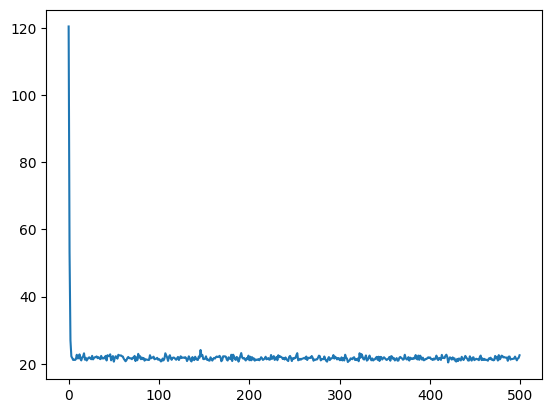

In [19]:
plt.plot(all_cost)

In [20]:
y_pred = []
y_true = []
net.train = False
for inp, label in test_loder:
    y_pred.append(net(inp).detach().numpy())
    y_true.append(label.numpy())

In [21]:
for i in range(len(y_pred)):
    for j in range(len(y_pred[0])):
        try:
            print(y_pred[i][j], y_true[i][j])
        except:
            pass

[26.006836] 23.1
[26.032566] 20.3
[25.99865] 16.1
[26.549393] 41.3
[26.437595] 29.0
[26.685978] 31.0
[25.541302] 10.4
[26.175472] 21.7
[25.93309] 14.2
[26.011887] 23.1
[26.175133] 24.7
[26.014595] 17.1
[26.687927] 37.6
[26.028595] 18.4
[25.985905] 19.4
[27.207134] 48.8
[25.82404] 15.4
[25.97879] 20.6
[25.943066] 27.9
[26.08715] 26.4
[25.945114] 19.6
[25.66626] 13.8
[26.090324] 23.9
[25.999596] 20.6
[26.006836] 24.5
[26.006279] 20.4
[26.104908] 25.0
[26.00188] 19.7
[26.035713] 23.2
[26.659374] 43.8
[25.989075] 13.1
[25.65165] 13.8
[26.00039] 14.0
[26.243145] 19.4
[25.993496] 18.9
[25.8391] 27.5
[26.006836] 21.2
[25.730911] 14.1
[25.965908] 16.7
[25.533657] 8.3
[27.31799] 50.0
[25.659534] 12.7
[26.054543] 26.6
[26.717663] 44.8
[26.058819] 17.4
[26.708473] 30.3
[25.943417] 17.3
[25.982487] 23.0
[25.993229] 16.6
[26.22993] 36.1
[26.431034] 33.4
[26.091812] 22.6
[26.026226] 22.8
[26.47586] 34.9
[25.922989] 7.0
[25.7429] 15.0
[26.655155] 32.2
[26.065166] 24.4
[25.984234] 19.6
[25.647835] 13.

In [22]:
y_true

[array([23.1, 20.3, 16.1, 41.3, 29. , 31. , 10.4, 21.7, 14.2, 23.1, 24.7,
        17.1, 37.6, 18.4, 19.4, 48.8, 15.4, 20.6, 27.9, 26.4, 19.6, 13.8,
        23.9, 20.6, 24.5, 20.4, 25. , 19.7, 23.2, 43.8, 13.1, 13.8, 14. ,
        19.4, 18.9, 27.5, 21.2, 14.1, 16.7,  8.3], dtype=float32),
 array([50. , 12.7, 26.6, 44.8, 17.4, 30.3, 17.3, 23. , 16.6, 36.1, 33.4,
        22.6, 22.8, 34.9,  7. , 15. , 32.2, 24.4, 19.6, 13.1, 23. , 22.4,
        20.7, 11.7,  9.7, 15.2, 19.4,  8.8, 21.4, 17.6, 17.2, 21.5, 24.1,
        24.7, 26.4, 12.1, 22.7, 27.1, 25.1, 22.2], dtype=float32),
 array([22.6, 16.8, 20.5, 35.2, 12.7, 17.5, 21.4, 18.6, 13.5, 19.7, 24.1,
        13.8, 19.6, 10.8, 50. , 23.9, 22.1, 26.5, 50. , 23.2, 17.9, 18.7,
         8.3, 17.8, 50. , 18.4, 24.3, 30.1, 23.4, 20.3, 19.6, 30.1, 22.2,
         7. , 27.9, 14.4, 24.8, 21.7, 28.6, 13.1], dtype=float32),
 array([13. ,  8.1, 19. , 15.6, 16.2, 21.4, 33.2], dtype=float32)]